## 读取数据集

In [1]:
import pandas as pd
import shutil
df = pd.read_csv('./cleaned/small.csv',sep='|')
df.head()

,English,中文
0,‘Good biz; ‘ere’s an organ!’ cried half a doze...,'好家伙，这有一架风琴！'一下子就有六七个人叫了起来。
1,"The organ-man was an Italian, with a shock of ...",风琴手是个意大利人，一头黑发，留着凶狠的小胡子。他把风琴拉到一个有利的位置，停了下来，松开肩...
2,"‘Come on, Florrie, you and me ain’t shy; we’ll...","来吧，弗洛莉，你和我都不害羞；我们开始吧，跳个痛快！""两个女孩互相拉着对方的手。"
3,"The two girls took hold of one another, one ac...",两个女孩拉住了对方，一个扮演绅士，另一个扮演淑女；又有三四对女孩立即加入了她们，她们开始跳华...
4,All at once there was a cry: ‘There’s Liza!’ A...,"突然，有人喊道：""莉莎在那儿！""。几个人转过身来喊道噢，快看莉莎！""。"


## 模型和简单的训练一下

## 分词

In [2]:
import pandas as pd
import jieba
import spacy
from collections import defaultdict

# 加载 SpaCy 英文分词模型
nlp = spacy.load("en_core_web_sm")

# 分词函数，分别处理中文和英文
def tokenize_text(row):
    # 中文分词
    chinese_tokens = list(jieba.cut(row["中文"]))
    # 英文分词（使用 SpaCy）
    english_tokens = [token.text.lower() for token in nlp(row["English"])]
    return chinese_tokens, english_tokens

# 应用分词到 DataFrame
df["tokens"] = df.apply(tokenize_text, axis=1)

# 构建独立的中英文词汇表
chinese_vocab = defaultdict(int)
english_vocab = defaultdict(int)

for tokens in df["tokens"]:
    chinese_tokens, english_tokens = tokens
    for word in chinese_tokens:
        chinese_vocab[word] += 1
    for word in english_tokens:
        english_vocab[word] += 1

# 定义特殊标记
PAD_TOKEN = 'PAD'
BOS_TOKEN = 'BOS'
EOS_TOKEN = 'EOS'

# 分别为中文和英文分配唯一索引，首先添加 PAD, BOS, EOS
def build_word2index(vocab, pad_token=PAD_TOKEN, bos_token=BOS_TOKEN, eos_token=EOS_TOKEN):
    word2index = {pad_token: 0, bos_token: 1, eos_token: 2}
    for idx, (word, _) in enumerate(vocab.items(), start=3):
        word2index[word] = idx
    return word2index

chinese_word2index = build_word2index(chinese_vocab)
english_word2index = build_word2index(english_vocab)

# 反向词汇表（如果需要）
chinese_index2word = {idx: word for word, idx in chinese_word2index.items()}
english_index2word = {idx: word for word, idx in english_word2index.items()}

# 为每行生成独立的中文和英文索引列表
def tokens_to_indices(row):
    chinese_tokens, english_tokens = row["tokens"]
    # 分别映射为索引，并添加 BOS 和 EOS
    chinese_indices = [chinese_word2index[BOS_TOKEN]] + \
                      [chinese_word2index.get(token, chinese_word2index[PAD_TOKEN]) for token in chinese_tokens] + \
                      [chinese_word2index[EOS_TOKEN]]
    english_indices = [english_word2index[BOS_TOKEN]] + \
                      [english_word2index.get(token, english_word2index[PAD_TOKEN]) for token in english_tokens] + \
                      [english_word2index[EOS_TOKEN]]
    return chinese_indices, english_indices

# 应用索引生成
df["indices"] = df.apply(tokens_to_indices, axis=1)

# 查看结果
df[["tokens", "indices"]].iloc[20]




Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Zhouyuan\AppData\Local\Temp\jieba.cache
Loading model cost 0.436 seconds.
Prefix dict has been built successfully.


tokens            ([', 这是, 果酱, ！], [‘, this, is, jam, !, ’])
indices    ([1, 3, 51, 312, 9, 2], [1, 3, 289, 290, 291, ...
Name: 20, dtype: object

In [3]:
# 中文和英文的字典大小
chinese_vocab_size = len(chinese_word2index) + 1
english_vocab_size = len(english_word2index) + 1
chinese_vocab_size, english_vocab_size

(321, 298)

## Dataset

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.src_sequences = self.data['indices'].apply(lambda x: x[1]).tolist()  # English indices作为源语言
        self.tgt_sequences = self.data['indices'].apply(lambda x: x[0]).tolist()  # Chinese indices作为目标语言

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'src': torch.tensor(self.src_sequences[idx], dtype=torch.long),
            'tgt': torch.tensor(self.tgt_sequences[idx], dtype=torch.long)
        }

def collate_fn(batch):
    src_batch = [item['src'] for item in batch]
    tgt_batch = [item['tgt'] for item in batch]
    
    # 分别填充源和目标序列
    src_padded = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=english_word2index[PAD_TOKEN], batch_first=True)
    tgt_padded = torch.nn.utils.rnn.pad_sequence(tgt_batch, padding_value=chinese_word2index[PAD_TOKEN], batch_first=True)
    
    # 创建掩码
    src_mask = (src_padded != english_word2index[PAD_TOKEN]).unsqueeze(-2)
    tgt_mask = (tgt_padded != chinese_word2index[PAD_TOKEN]).unsqueeze(-2)
    
    size = tgt_padded.size(1)
    nopeak_mask = torch.triu(torch.ones((1, size, size), device=tgt_padded.device), diagonal=1).bool()
    tgt_mask = tgt_mask & ~nopeak_mask

    return src_padded, tgt_padded, src_mask, tgt_mask

# 创建 Dataset 和 DataLoader
dataset = TranslationDataset(df)
batch_size = 2  # 根据数据量调整
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


In [5]:
import torch
import torch.nn as nn
import math
import copy
import torch.nn.functional as F
from model import init_model

# 假设您已经定义了所有需要的模型类，如 Embeddings, PositionalEncoding, MultiHeadedAttention 等
# 并且 `init_model` 函数已经正确加载

# 获取词汇表大小
src_vocab_size = len(english_word2index)  # 已经包含 PAD, BOS, EOS
tgt_vocab_size = len(chinese_word2index)  # 已经包含 PAD, BOS, EOS

# 初始化模型
model = init_model(src_vocab=src_vocab_size, tgt_vocab=tgt_vocab_size, N=2, d_model=256, d_ff=512, h=8)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(ignore_index=chinese_word2index[PAD_TOKEN])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


d:\miniconda\envs\anime\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import copy

# 保存训练前的嵌入权重
src_embedding_before = copy.deepcopy(model.src_embed[0].lut.weight.data.cpu().numpy())
tgt_embedding_before = copy.deepcopy(model.tgt_embed[0].lut.weight.data.cpu().numpy())

num_epochs = 100
model.train()

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for batch_idx, (src, tgt, src_mask, tgt_mask) in enumerate(dataloader):
        src = src.to(model.src_embed[0].lut.weight.device)
        tgt = tgt.to(model.tgt_embed[0].lut.weight.device)
        src_mask = src_mask.to(model.src_embed[0].lut.weight.device)
        tgt_mask = tgt_mask.to(model.src_embed[0].lut.weight.device)
        
        optimizer.zero_grad()
        
        # 输入和目标
        output = model(src, tgt[:, :-1], src_mask, tgt_mask[:, :-1, :-1])
        # 输出的维度: [batch_size, tgt_seq_len -1, d_model]
        output = output.view(-1, tgt_vocab_size)
        tgt_out = tgt[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, tgt_out)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if batch_idx % 100 == 0 and epoch % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    avg_loss = epoch_loss / len(dataloader)
    if epoch % 10 == 0:
        print(f'Epoch {epoch} 完成，平均损失: {avg_loss:.4f}')

# 保存训练后的嵌入权重
src_embedding_after = model.src_embed[0].lut.weight.data.cpu().numpy()
tgt_embedding_after = model.tgt_embed[0].lut.weight.data.cpu().numpy()


Epoch 10, Batch 0, Loss: 4.8908
Epoch 10 完成，平均损失: 4.7404
Epoch 20, Batch 0, Loss: 3.3822
Epoch 20 完成，平均损失: 3.7741
Epoch 30, Batch 0, Loss: 2.9298
Epoch 30 完成，平均损失: 3.0131
Epoch 40, Batch 0, Loss: 2.4273
Epoch 40 完成，平均损失: 2.1626
Epoch 50, Batch 0, Loss: 1.7083
Epoch 50 完成，平均损失: 1.6732
Epoch 60, Batch 0, Loss: 1.1280
Epoch 60 完成，平均损失: 1.2274
Epoch 70, Batch 0, Loss: 1.0065
Epoch 70 完成，平均损失: 0.9520
Epoch 80, Batch 0, Loss: 0.6432
Epoch 80 完成，平均损失: 0.7495
Epoch 90, Batch 0, Loss: 0.6404
Epoch 90 完成，平均损失: 0.5947
Epoch 100, Batch 0, Loss: 0.8478
Epoch 100 完成，平均损失: 0.4527


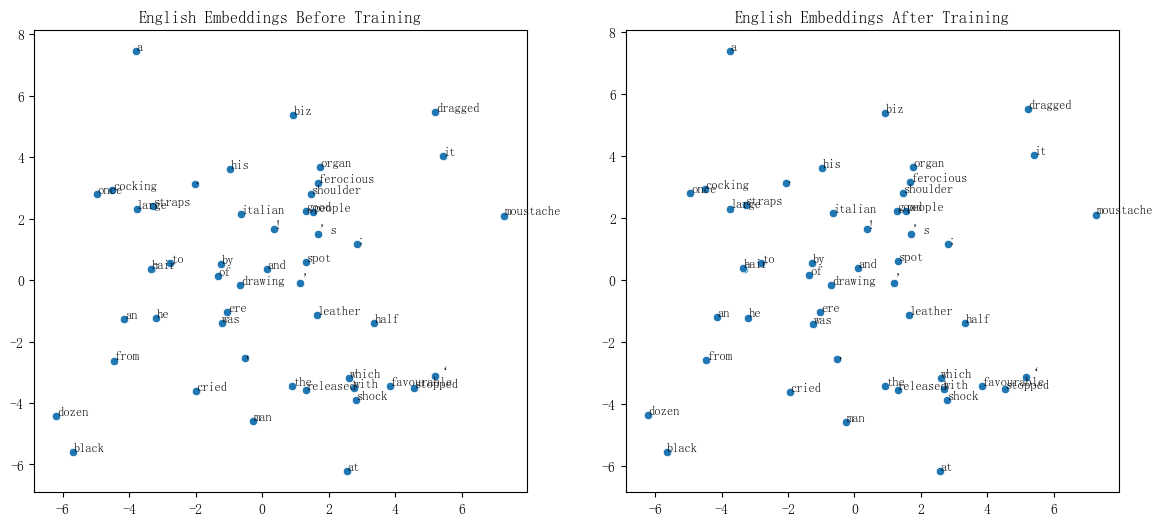

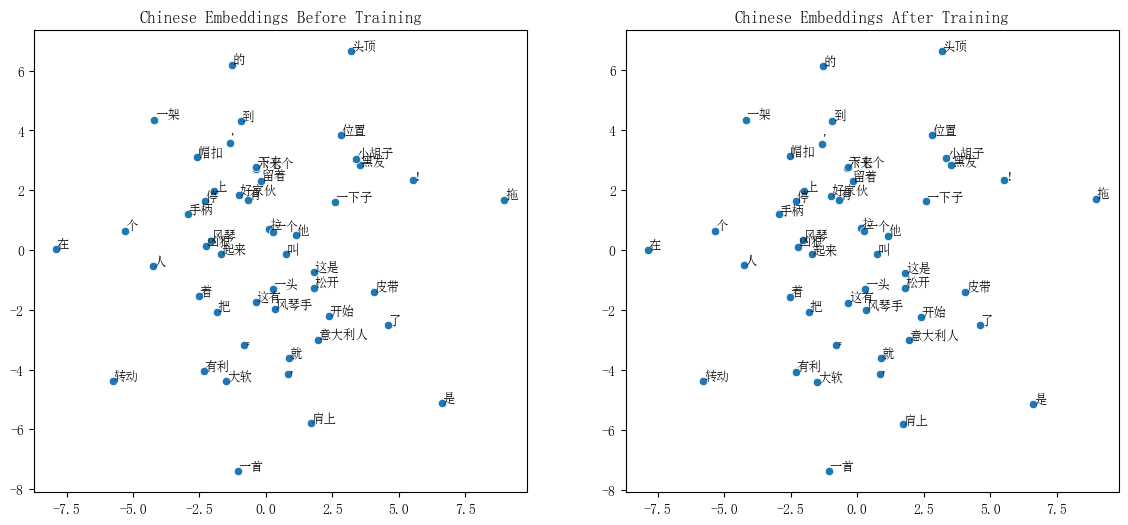

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import rcParams

# 配置字体（以 SimSun 宋体为例，确保系统安装了这个字体）
rcParams['font.family'] = 'SimSun'  # 或 'Microsoft YaHei'，根据您的系统选择字体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def visualize_embeddings(embeddings_before, embeddings_after, word2index, index2word, num_words=50, title=''):
    # 排除特殊标记，选择前 num_words 个实际词汇
    words = [word for word in word2index.keys() if word not in [PAD_TOKEN, BOS_TOKEN, EOS_TOKEN]]
    words = words[:num_words]
    indices = [word2index[word] for word in words]
    
    emb_before = embeddings_before[indices]
    emb_after = embeddings_after[indices]
    
    # 使用 PCA 降维
    pca = PCA(n_components=2)
    emb_before_pca = pca.fit_transform(emb_before)
    emb_after_pca = pca.transform(emb_after)
    
    plt.figure(figsize=(14, 6))
    
    # 训练前的嵌入
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=emb_before_pca[:,0], y=emb_before_pca[:,1])
    for i, word in enumerate(words):
        plt.text(emb_before_pca[i,0]+0.02, emb_before_pca[i,1]+0.02, word, fontsize=9)
    plt.title(f'{title} Embeddings Before Training')
    
    # 训练后的嵌入
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=emb_after_pca[:,0], y=emb_after_pca[:,1])
    for i, word in enumerate(words):
        plt.text(emb_after_pca[i,0]+0.02, emb_after_pca[i,1]+0.02, word, fontsize=9)
    plt.title(f'{title} Embeddings After Training')
    
    plt.show()

# 可视化英文嵌入
visualize_embeddings(
    src_embedding_before, src_embedding_after, 
    english_word2index, english_index2word, 
    num_words=50, title='English'
)

# 可视化中文嵌入
visualize_embeddings(
    tgt_embedding_before, tgt_embedding_after, 
    chinese_word2index, chinese_index2word, 
    num_words=50, title='Chinese'
)


In [18]:
from decoder import beam_search

def translate_sentence_beam(model, src_text, src_word2index, tgt_index2word, 
                            pad_token="PAD", bos_token="BOS", eos_token="EOS", 
                            beam_size=5, max_len=50, device="cuda"):
    """
    使用 Beam Search 解码方式翻译源语言句子为目标语言句子。
    
    参数：
    - model: Transformer 模型
    - src_text: str，输入的源语言句子（英文）
    - src_word2index: dict，源语言的词到索引映射
    - tgt_index2word: dict，目标语言的索引到词映射
    - pad_token: str，填充标记
    - bos_token: str，开始标记
    - eos_token: str，结束标记
    - beam_size: int，Beam Search 的宽度
    - max_len: int，最大解码长度
    - device: str，运行设备
    
    返回：
    - str，翻译后的目标语言句子（中文）
    """
    # 模型切换为评估模式
    model.eval()

    # Step 1: 文本预处理，将英文转为索引
    tokens = [token.lower() for token in src_text.split()]
    src_indices = [src_word2index[bos_token]] + \
                  [src_word2index.get(token, src_word2index[pad_token]) for token in tokens] + \
                  [src_word2index[eos_token]]
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)  # (1, seq_len)
    src_mask = (src_tensor != src_word2index[pad_token]).unsqueeze(-2)  # (1, 1, seq_len)

    # Step 2: 使用 Beam Search 生成翻译结果
    pad_idx = src_word2index[pad_token]
    bos_idx = src_word2index[bos_token]
    eos_idx = src_word2index[eos_token]
    batch_hyp, _ = beam_search(
        model=model,
        src=src_tensor,
        src_mask=src_mask,
        max_len=max_len,
        pad=pad_idx,
        bos=bos_idx,
        eos=eos_idx,
        beam_size=beam_size,
        device=device
    )
    
    # Step 3: 处理 Beam Search 的输出，选择得分最高的翻译
    translated_indices = batch_hyp[0][0]  # 取第一个句子的最佳翻译结果
    
    # Step 4: 将索引转换为中文句子
    translated_sentence = []
    for idx in translated_indices:
        word = tgt_index2word[idx]
        if word == eos_token:  # 如果遇到EOS标记，停止翻译
            break
        translated_sentence.append(word)
    
    return "".join(translated_sentence)  # 将中文词拼接成完整句子


In [19]:
# 示例英文句子
src_sentence = "This is a test."

# 调用翻译函数
translated_sentence = translate_sentence_beam(
    model=model,  # 已加载的 Transformer 模型
    src_text=src_sentence,  # 输入英文句子
    src_word2index=english_word2index,  # 英文词到索引的映射
    tgt_index2word=chinese_index2word,  # 中文索引到词的映射
    pad_token="PAD",
    bos_token="BOS",
    eos_token="EOS",
    beam_size=5,  # 设置 Beam Size
    max_len=50,  # 最大解码长度
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 设备
)

# 输出结果
print(f"英文句子: {src_sentence}")
print(f"翻译结果: {translated_sentence}")


英文句子: This is a test.
翻译结果: '这是果酱！


## 下一步是，扩大我们的数据集